In [39]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# O2 flux

##### RUN:
/data/tjarniko/results/20aug19_writeout_oxydiag_uncomm_zkgwan_writeout_windmag
##### DATE:  Jan17_2019
##### description of point: 

calculate intermediate calculations for oxygen flux. 
check units/check that numbers make sense with literature



In [40]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [41]:
#import all the things

import netCDF4 as nc
import matplotlib.pyplot as plt
import datetime
import os
import numpy as np
import cmocean as cm
from salishsea_tools import visualisations as vis
from salishsea_tools import (teos_tools, tidetools, viz_tools)
import xarray as xr 
import subprocess 
import cmocean
from matplotlib import reload
import glob
import netCDF4 as nc
import VIZ_plots as VP

%matplotlib inline

Oxygen is exchanged with the atmosphere using the parameterization
of Wanninkhof (1992) to compute the gas exchange
coefficient. The atmospheric concentration of oxygen
is constant over time and space and cannot be specified by
the user. As for CO2, no air–sea fluxes are allowed when the
ocean is covered by sea ice (see Eq. 82).

In [42]:
reload(VP)

<module 'VIZ_plots' from '/data/tjarniko/MEOPAR/analysis-tereza/notebooks/carbon_dev/MOCSY_and_FLUX/VIZ_plots.py'>

#### Available functions from VP

    two_panel_plot(surfdat_1,surfdat_2,tit1,tit2,t_cmap,xsize,ysize,vmin,vmax,clabel,bigtit)
    animate_surf(hrly_dat,tit,v_min,v_max,t_cmap)

In [43]:
resdir = '/data/tjarniko/results/20aug19_writeout_oxydiag_uncomm_zkgwan_writeout_windmag/'
ptrc = 'SKOG_1ts_20141121_20141121_carp_T_20141121-20141121.nc'
grid = 'SKOG_1ts_20141121_20141121_grid_T_20141121-20141121.nc'
tracers = nc.Dataset(resdir + ptrc)
tracersp = nc.Dataset(resdir + grid)
#print(tracers)
# print(tracersp)

In [46]:
chemo2 = tracers.variables['of_chemo2'][0,:,:]
zkgo2 = tracers.variables['of_zkgo2'][0,:,:]
#patm = tracers.variables['of_patm'][0,:,:]
o2_surf = tracers.variables['dissolved_oxygen'][0,0,:,:]
oce_o2 = tracers.variables['oce_o2'][0,:,:]
wm = tracers.variables['wind_mag'][0,:,:]
sal = tracersp.variables['vosaline'][0,0,:,:]
temp = tracersp.variables['votemper'][0,0,:,:]


In [47]:
print('chemo2')
print(np.min(chemo2))
print(np.max(chemo2))
print('zkgo2')
print(np.min(zkgo2))
print(np.max(zkgo2))

chemo2
0.00027572436
0.00039639758
zkgo2
0.0
7.9941914e-05


In [48]:

# print('patm')
# print(np.min(patm))
# print(np.max(patm))
print('oce_o2')
print(np.min(oce_o2))
print(np.max(oce_o2))
print('o2_surf')
print(np.min(o2_surf))
print(np.max(o2_surf))
print('wind_mag')
print(np.min(wm))
print(np.max(wm))


oce_o2
-0.0061143506
0.0042647067
o2_surf
0.0
475.1812
wind_mag
0.0
11.721901


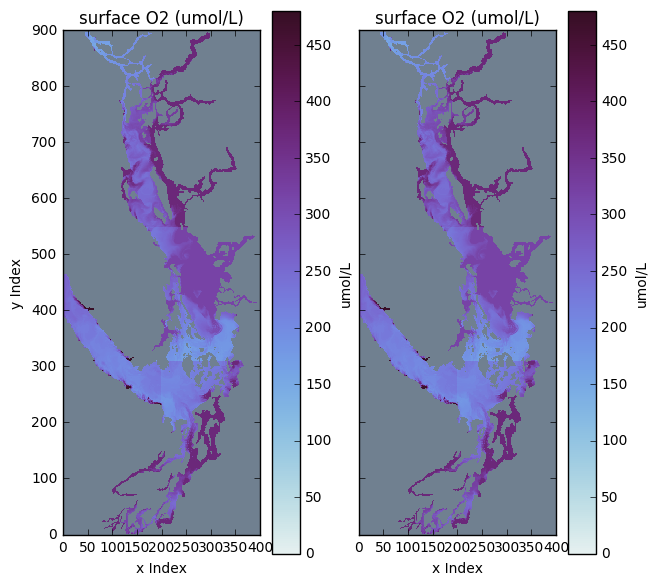

In [51]:
VP.two_panel_plot(o2_surf,o2_surf,'surface O2 (umol/L)','surface O2 (umol/L)',\
                  cm.cm.dense,7,7,0,480,0,480,'umol/L','umol/L','')


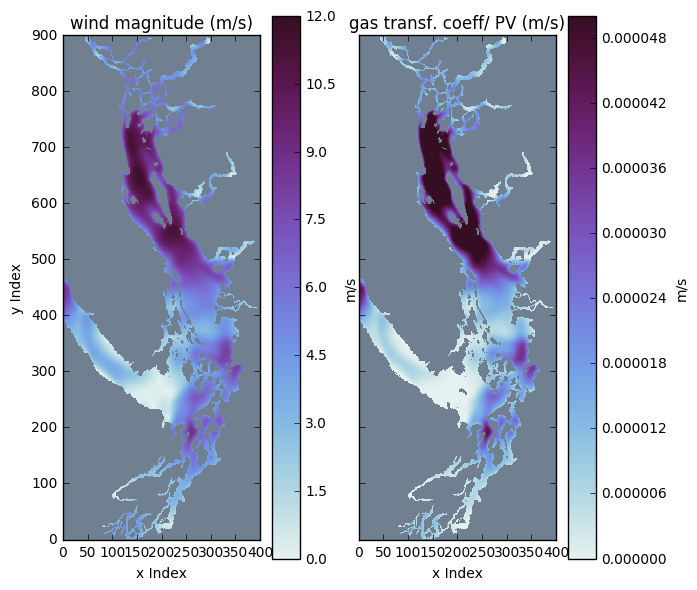

In [52]:
VP.two_panel_plot(wm,zkgo2,'wind magnitude (m/s)','gas transf. coeff/ PV (m/s)',\
                  cm.cm.dense,7,7,0,12,0,5e-5,'m/s','m/s','')


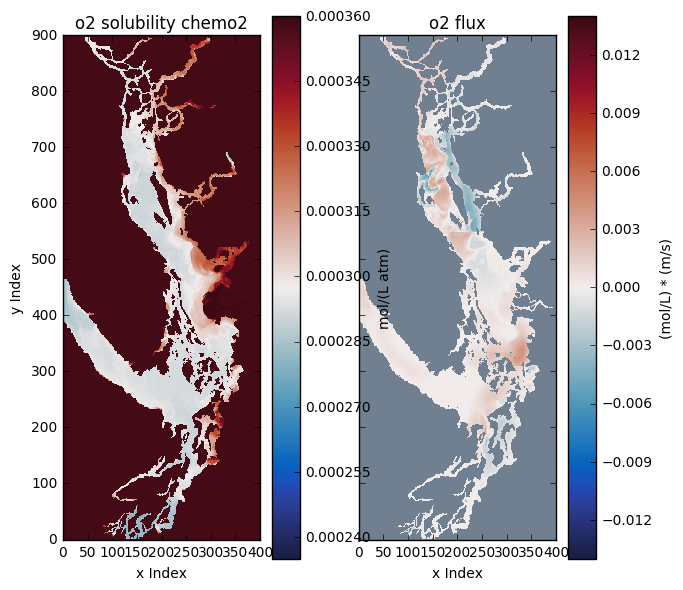

In [53]:
VP.two_panel_plot(chemo2,oce_o2,'o2 solubility chemo2','o2 flux',\
                  cm.cm.balance,7,7,.000235,.00036,-0.014,0.014,'mol/(L atm)','(mol/L) * (m/s)','')

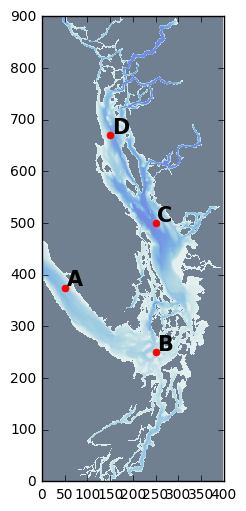

In [54]:
mesh = nc.Dataset('/data/tjarniko/MEOPAR/grid/bathymetry_201702.nc')
bathy = mesh.variables['Bathymetry'][:]

itt = [50,250,250,150]
jtt = [375,250,500,670]
wtt = ['A','B','C','D']
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
viz_tools.set_aspect(ax)
mesh = ax.pcolormesh(bathy, cmap=cmocean.cm.dense, vmin = 0, vmax = 1000)
for w in range(0,len(wtt)):

        ax.plot(itt[w],jtt[w],'r.',markersize=10)
        ax.text(itt[w]+4,jtt[w]+4,wtt[w],fontsize=15,weight='bold')

In [55]:
#o2 conc, temp, sal, schmidt number, wind mag, pist_vel, 
itt = [50.0,250.0,250,150]
jtt = [375,250,500,670]
temptt = np.zeros_like(itt)
saltt = np.zeros_like(itt)
windtt = np.zeros_like(itt)
schtt = np.zeros_like(itt)
pisttt= np.zeros_like(itt)
o2_conc = np.zeros_like(itt)
o2_sol  = np.zeros_like(itt)
o2_flx = np.zeros_like(itt)
itt = [50,250,250,150]

for w in range(0,len(itt)):
    temptt[w] = temp[jtt[w],itt[w]]
    saltt[w]= sal[jtt[w],itt[w]]
    windtt[w]= wm[jtt[w],itt[w]]
    ztc = temptt[w]
    sc_o2  = 1920.4 - 135.6  * ztc + 5.2122 * ztc**2 - 0.109390 * ztc**3 + 0.0009377 * ztc**4
    schtt[w] = sc_o2
    pisttt[w] = zkgo2[jtt[w],itt[w]]
    o2_sol[w] = chemo2[jtt[w],itt[w]]
    o2_flx[w] = oce_o2[jtt[w],itt[w]]
    o2_conc[w] = o2_surf[jtt[w],itt[w]]


In [ ]:
print(pisttt)

In [56]:
import pandas as pd


dataset = pd.DataFrame({'i':itt,'j':jtt,'temp (C)':temptt,\
                        'sal':saltt,'schmidt':schtt,'wind (m/s)':windtt,\
                       'pist.vel.(m/s)':pisttt,'o2 sol (mol/(L atm))':o2_sol,\
                        'o2 flux (mmol/L) * (m/s)':o2_flx,'surface o2 (umol/L)':o2_conc})
print(dataset)


     i    j  o2 flux (mmol/L) * (m/s)  o2 sol (mol/(L atm))  pist.vel.(m/s)  \
0   50  375                  0.000622              0.000291        0.000009   
1  250  250                  0.001062              0.000292        0.000016   
2  250  500                 -0.000064              0.000295        0.000048   
3  150  670                  0.001920              0.000290        0.000072   

       sal      schmidt  surface o2 (umol/L)  temp (C)  wind (m/s)  
0  31.8750  1020.396214           224.372131    9.4375    4.093434  
1  31.0000  1016.450424           225.681290    9.5000    5.343256  
2  26.8125   966.966347           295.590698   10.3125    9.172828  
3  28.8750   959.643501           262.522430   10.4375   11.178541  
